In [1]:
import torch
import numpy as np
import os
import shutil
from tqdm import tqdm
import yaml

import sys
import os

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import my_code.diffusion_training_sign_corr.data_loading as data_loading

import networks.diffusion_network as diffusion_network
import matplotlib.pyplot as plt
import my_code.utils.plotting_utils as plotting_utils
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
import argparse
from pyFM_fork.pyFM.refine.zoomout import zoomout_refine
import my_code.utils.zoomout_custom as zoomout_custom

import accelerate
import sqlite3

from utils.shape_util import compute_geodesic_distmat
from my_code.utils.median_p2p_map import get_median_p2p_map


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class Arguments:
    def __init__(self):
        self.experiment_name = 'pair_5_xy_64_64_128_128'
        self.checkpoint_name = 'epoch_99'
        self.dataset_name = 'SHREC19_r_pair'
        self.split = 'test'
        self.num_iters_avg = 50
        
args = Arguments()

In [3]:

# configuration
experiment_name = args.experiment_name
checkpoint_name = args.checkpoint_name

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"])

if "accelerate" in config and config["accelerate"]:
    accelerate.load_checkpoint_in_model(model, f"{exp_base_folder}/checkpoints/{checkpoint_name}/model.safetensors")
else:
    model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}"))

model = model.to('cuda')

### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    **config["sign_net"]["net_params"]
    ).to('cuda')
    # in_channels=128,
    # out_channels=config["model_params"]["sample_size"] // config["evecs_per_support"],
    # cache_dir=None,
    # input_type=config["net_input_type"],
    # k_eig=128,
    # n_block=2 
    

sign_corr_net.load_state_dict(torch.load(
        f'{config["sign_net"]["net_path"]}/{config["sign_net"]["n_iter"]}.pth'
        ))


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 


### test dataset
dataset_name = args.dataset_name
split = args.split

single_dataset, test_dataset = data_loading.get_val_dataset(
    dataset_name, split, 200, preload=False, return_evecs=True
    )
sign_corr_net.cache_dir = single_dataset.lb_cache_dir


num_evecs = config["model_params"]["sample_size"]

##########################################
# Logging
##########################################

log_dir = f'{exp_base_folder}/eval/{checkpoint_name}/{dataset_name}-{split}/no_smoothing'
os.makedirs(log_dir, exist_ok=True)

fig_dir = f'{log_dir}/figs'
os.makedirs(fig_dir, exist_ok=True)

log_file_name = f'{log_dir}/log.txt'

##########################################

In [6]:

ratios = []
geo_errs = []
geo_errs_zo = []

geo_errs_median = []
geo_errs_zo_median = []
geo_errs_median_p2p = []

Cxy_est_list = []
C_gt_xy_corr_list = []


# data_range = tqdm(range(len(test_dataset)))

# data_range = tqdm(range(2))
# print('!!!!!! Data range limited to 10 !!!!!!!')

data_range = [289]

# data_range = range(len(test_dataset))

for i in data_range:

    data = test_dataset[i]
    
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = data['first']['verts'].unsqueeze(0).to(device)
    verts_second = data['second']['verts'].unsqueeze(0).to(device)
    
    faces_first = data['first']['faces'].unsqueeze(0).to(device)
    faces_second = data['second']['faces'].unsqueeze(0).to(device)

    evecs_first = data['first']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    evecs_second = data['second']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    
    evals_first = data['first']['evals'][:num_evecs]
    evals_second = data['second']['evals'][:num_evecs]

    corr_first = data['first']['corr']
    corr_second = data['second']['corr']
    
    if config["sign_net"]["with_mass"]:
        mass_mat_first = torch.diag_embed(
            data['first']['mass'].unsqueeze(0)
            ).to(device)
        mass_mat_second = torch.diag_embed(
            data['second']['mass'].unsqueeze(0)
            ).to(device)
    else:
        mass_mat_first = None
        mass_mat_second = None


    # predict the sign change
    with torch.no_grad():
        sign_pred_first, support_vector_norm_first, _ = predict_sign_change(
            sign_corr_net, verts_first, faces_first, evecs_first, 
            mass_mat=mass_mat_first, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['first']['mass'].unsqueeze(0), L=data['first']['L'].unsqueeze(0),
            evals=data['first']['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            evecs=data['first']['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            gradX=data['first']['gradX'].unsqueeze(0), gradY=data['first']['gradY'].unsqueeze(0)
            )
        sign_pred_second, support_vector_norm_second, _ = predict_sign_change(
            sign_corr_net, verts_second, faces_second, evecs_second, 
            mass_mat=mass_mat_second, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['second']['mass'].unsqueeze(0), L=data['second']['L'].unsqueeze(0),
            evals=data['second']['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            evecs=data['second']['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            gradX=data['second']['gradX'].unsqueeze(0), gradY=data['second']['gradY'].unsqueeze(0)
            )

    # correct the evecs
    evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
    evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
    
    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
    
    # product with support
    # evecs_cond_first = evecs_first_corrected_norm.transpose(0, 1) @ support_vector_norm_first[0].cpu()
    # evecs_cond_second = evecs_second_corrected_norm.transpose(0, 1) @ support_vector_norm_second[0].cpu()


    # product with support
    if config["sign_net"]["with_mass"]:
    # if config["sign_net"]['cond_mass_normalize']:
        
        mass_mat_first = torch.diag_embed(
            data['first']['mass'].unsqueeze(0)
            ).to(device)
        mass_mat_second = torch.diag_embed(
            data['second']['mass'].unsqueeze(0)
            ).to(device)
        
        evecs_cond_first = torch.nn.functional.normalize(
            support_vector_norm_first[0].cpu().transpose(0, 1) \
                @ mass_mat_first[0].cpu(),
            p=2, dim=1) \
                @ evecs_first_corrected_norm
        
        evecs_cond_second = torch.nn.functional.normalize(
            support_vector_norm_second[0].cpu().transpose(0, 1) \
                @ mass_mat_second[0].cpu(),
            p=2, dim=1) \
                @ evecs_second_corrected_norm 
        
    else:
        evecs_cond_first = support_vector_norm_first[0].cpu().transpose(0, 1) @ evecs_first_corrected_norm
        evecs_cond_second = support_vector_norm_second[0].cpu().transpose(0, 1) @ evecs_second_corrected_norm
    


    # gt corrected fmap
    C_gt_xy_corr = torch.linalg.lstsq(
        evecs_second_corrected[corr_second],
        evecs_first_corrected[corr_first]
        ).solution
    
    # gt original fmap
    C_gt_xy = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second],
        evecs_first.cpu()[0, corr_first]
        ).solution
    
    
    ###############################################
    # Conditioning
    ###############################################

    conditioning = torch.tensor([])
    
    if 'evals' in config["conditioning_types"]:
        eval = evals_second.unsqueeze(0)
        eval = torch.diag_embed(eval)
        conditioning = torch.cat((conditioning, eval), 0)
    
    if 'evals_inv' in config["conditioning_types"]:
        eval_inv = 1 / evals_second.unsqueeze(0)
        # replace elements > 1 with 1
        eval_inv[eval_inv > 1] = 1
        eval_inv = torch.diag_embed(eval_inv)
        conditioning = torch.cat((conditioning, eval_inv), 0)
    
    if 'evecs' in config["conditioning_types"]:
        evecs_cond_full = torch.cat(
            (evecs_cond_first.unsqueeze(0), evecs_cond_second.unsqueeze(0)),
            0)
        conditioning = torch.cat((conditioning, evecs_cond_full), 0)
    
    
    ###############################################
    # Sample the model
    ###############################################
    
    # x_sampled = torch.rand(1, 1, model.model.sample_size, model.model.sample_size).to(device)
    # y = conditioning.unsqueeze(0).to(device) 
    
    x_sampled = torch.rand(args.num_iters_avg, 1, model.model.sample_size, model.model.sample_size).to(device)
    
    # repeat conditioning for each sample, [num_iters_avg, n_channels, model.sample_size, model.sample_size]
    y = conditioning.unsqueeze(0).repeat(args.num_iters_avg, 1, 1, 1).to(device)
    
    
    # print(x_sampled.shape, y.shape)
        
    # Sampling loop
    for t in noise_scheduler.timesteps:

        # Get model pred
        with torch.no_grad():
            residual = model(x_sampled, t,
                                conditioning=y
                                ).sample

        # Update sample with step
        x_sampled = noise_scheduler.step(residual, t, x_sampled).prev_sample

    # Cxy_est = x_sampled[0][0].cpu()
    
    dist_x = torch.tensor(
        compute_geodesic_distmat(data['first']['verts'].numpy(), data['first']['faces'].numpy())    
    )
    
    geo_err_est_sampled = []
    geo_err_est_zo_sampled = []
    p2p_est_zo_sampled = []
    
    for k in range(args.num_iters_avg):
        
        Cxy_est_k = x_sampled[k][0].cpu()
        
        ###############################################
        # Zoomout
        ###############################################
        
        evecs_first_zo = torch.cat(
            [evecs_first_corrected,
            data['first']['evecs'][:, num_evecs:]], 1)
        evecs_second_zo = torch.cat(
            [evecs_second_corrected,
            data['second']['evecs'][:, num_evecs:]], 1)
        
        C_xy_est_zo_k = zoomout_custom.zoomout(
            FM_12=Cxy_est_k.to(device), 
            evects1=evecs_first_zo.to(device), 
            evects2=evecs_second_zo.to(device),
            nit=evecs_first_zo.shape[1] - num_evecs, step=1,
            # nit=8, step=(evecs_first_zo.shape[1] - num_evecs) // 8,
        ).cpu()
        
        
        ###############################################
        # Evaluation
        ###############################################  
        
        # hard correspondence 
        p2p_gt = fmap_util.fmap2pointmap(
            C12=C_gt_xy,
            evecs_x=evecs_first.cpu()[0],
            evecs_y=evecs_second.cpu()[0],
            )
        p2p_corr_gt = fmap_util.fmap2pointmap(
            C12=C_gt_xy_corr,
            evecs_x=evecs_first_corrected,
            evecs_y=evecs_second_corrected,
            )
        p2p_est_k = fmap_util.fmap2pointmap(
            Cxy_est_k,
            evecs_x=evecs_first_corrected,
            evecs_y=evecs_second_corrected,
            )
        p2p_est_zo_k = fmap_util.fmap2pointmap(
            C_xy_est_zo_k,
            evecs_x=evecs_first_zo,
            evecs_y=evecs_second_zo,
            )
        
        # distance matrices
        # dist_x = torch.cdist(data['first']['verts'], data['first']['verts'])
        # dist_y = torch.cdist(data['second']['verts'], data['second']['verts'])

        # geodesic error
        geo_err_gt = geodist_metric.calculate_geodesic_error(
            dist_x, data['first']['corr'], data['second']['corr'], p2p_gt, return_mean=False
            )  
        geo_err_corr_gt = geodist_metric.calculate_geodesic_error(
            dist_x, data['first']['corr'], data['second']['corr'], p2p_corr_gt, return_mean=False
            )
        geo_err_est_k = geodist_metric.calculate_geodesic_error(
            dist_x, data['first']['corr'], data['second']['corr'], p2p_est_k, return_mean=False
            )
        geo_err_est_zo_k = geodist_metric.calculate_geodesic_error(
            dist_x, data['first']['corr'], data['second']['corr'], p2p_est_zo_k, return_mean=False
            )
        
        geo_err_est_sampled.append(geo_err_est_k.mean())
        geo_err_est_zo_sampled.append(geo_err_est_zo_k.mean())
        
        p2p_est_zo_sampled.append(p2p_est_zo_k)
        
    geo_err_est_sampled = torch.tensor(geo_err_est_sampled)
    geo_err_est_zo_sampled = torch.tensor(geo_err_est_zo_sampled)
    
    
    # median p2p map
    p2p_est_zo_sampled = torch.stack(p2p_est_zo_sampled)
    p2p_median = get_median_p2p_map(p2p_est_zo_sampled, dist_x)
    
    geo_err_est_zo_median = geodist_metric.calculate_geodesic_error(
        dist_x, data['first']['corr'], data['second']['corr'], p2p_median, return_mean=True
            )
    
    # print('geo_err_est_sampled', geo_err_est_sampled * 100)
    # print('geo_err_est_zo_sampled', geo_err_est_zo_sampled * 100)
    
    # print('geo_err_est_zo_median', geo_err_est_zo_median * 100)
    
    dirichlet_energy_list = []

    for n in range(p2p_est_zo_sampled.shape[0]):
        dirichlet_energy_list.append(
            # geo_err_est_zo_sampled[i].item()*100,
            dirichlet_energy(p2p_est_zo_sampled[n], verts_first[0].cpu(), data['second']['L']).item(),
            # orthogonality_energy(x_sampled[i][0].cpu()).item(),
            )
    dirichlet_energy_list = torch.tensor(dirichlet_energy_list)
    # sort by dirichlet energy
    # geo_errs_dirichlet_list.sort(key=lambda x: x[1])

    # get the index of the lowest geodesic error
    min_geo_err_idx = torch.argmin(geo_err_est_zo_sampled).item()
    
    min_dirichlet_energy_idx = torch.argmin(dirichlet_energy_list).item()
    
    print(i)
    print(f'min_geo_err idx {min_geo_err_idx}', 
          f'geo_err {geo_err_est_zo_sampled[min_geo_err_idx].item() * 100:.2f}',
          f'dirichlet energy {dirichlet_energy_list[min_geo_err_idx].item():.2f}')
    
    print(f'min_dirichlet_energy idx {min_dirichlet_energy_idx}',
          f'geo_err {geo_err_est_zo_sampled[min_dirichlet_energy_idx].item() * 100:.2f}',
          f'dirichlet energy {dirichlet_energy_list[min_dirichlet_energy_idx].item():.2f}')
    
    print(f'mean geo_err {geo_err_est_zo_sampled.mean().item() * 100:.2f}',
          f'max geo_err {geo_err_est_zo_sampled.max().item() * 100:.2f}',)
    
    # sort geo_err_est_zo_sampled, get the indices
    idxs_sorted = torch.argsort(geo_err_est_zo_sampled)
    
    print('geo_err_est_zo_sampled', geo_err_est_zo_sampled[idxs_sorted] * 100)
    print('dirichlet_energy_list', dirichlet_energy_list[idxs_sorted])
    
    print()
    

289
min_geo_err idx 11 geo_err 38.42 dirichlet energy 4.71
min_dirichlet_energy idx 27 geo_err 41.29 dirichlet energy 4.22
mean geo_err 40.49 max geo_err 42.66
geo_err_est_zo_sampled tensor([38.4164, 38.4431, 38.5568, 38.7922, 38.8030, 39.1552, 39.2304, 39.4923,
        39.5019, 39.6145, 39.6897, 39.7236, 39.7366, 39.7472, 39.7569, 39.7697,
        39.7701, 39.7715, 39.7865, 39.7961, 39.8312, 39.8878, 40.0404, 40.0639,
        40.1946, 40.2581, 40.3102, 40.3542, 40.7361, 41.1591, 41.2139, 41.2369,
        41.2917, 41.3573, 41.4355, 41.4538, 41.4621, 41.4957, 41.5003, 41.5536,
        41.6316, 41.6609, 41.7019, 41.7209, 41.7837, 42.0654, 42.1309, 42.4430,
        42.4812, 42.6629], dtype=torch.float64)
dirichlet_energy_list tensor([ 4.7080,  6.5103,  4.7041,  5.4652,  9.9419,  5.1186,  5.4789,  4.7465,
         4.7338,  4.4293,  4.5852,  4.8485,  4.8480,  4.8967,  4.8953,  4.5911,
        11.3333,  4.9628,  6.7198,  4.7443,  5.0307,  6.6215,  6.7908,  5.2318,
         5.5814,  4.7005,  

number 2 was 30, starting from 0

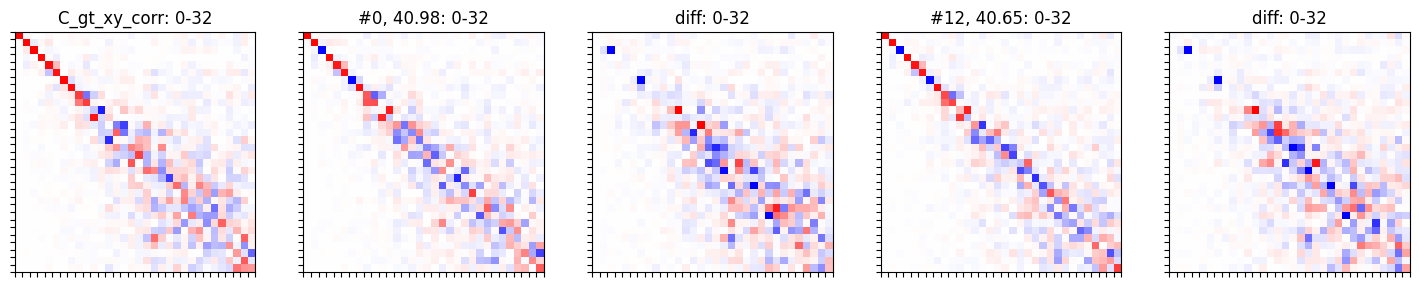

In [7]:
l = 0
h = 32

idx_0 = 0
idx_1 = 12

fig, axs = plt.subplots(1, 5, figsize=(18, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy_corr,
                        'C_gt_xy_corr', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1], x_sampled[idx_0][0].cpu(),
                        f'#{idx_0}, {geo_err_est_sampled[idx_0].item() * 100:.2f}',
                        l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], (x_sampled[idx_0][0].cpu() - C_gt_xy_corr).cpu(),
                        'diff', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[3], x_sampled[idx_1][0].cpu(),
                        f'#{idx_1}, {geo_err_est_sampled[idx_1].item() * 100:.2f}',
                        l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[4], (x_sampled[idx_1][0].cpu() - C_gt_xy_corr).cpu(),
                        'diff', l, h, show_grid=False, show_colorbar=False)


plt.show()

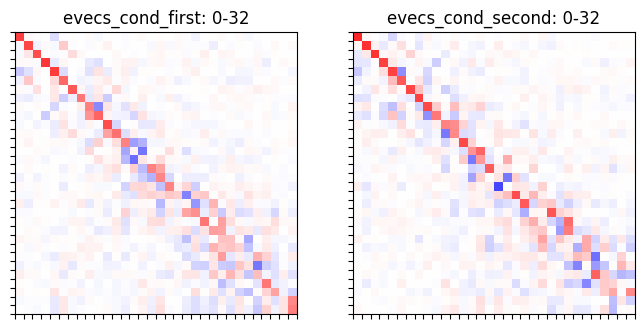

In [10]:
l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

plotting_utils.plot_Cxy(fig, axs[0], evecs_cond_first,
                        'evecs_cond_first', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], evecs_cond_second,
                        'evecs_cond_second', l, h, show_grid=False, show_colorbar=False)

plt.show()

# Dirichlet energy

In [18]:
p2p_est_zo_sampled.shape

torch.Size([16, 5200])

In [19]:
verts_first.shape, verts_second.shape

(torch.Size([1, 5197, 3]), torch.Size([1, 5200, 3]))

In [5]:
def dirichlet_energy(p2p_12, X_2, W_1):
    """
    p2p_12: point-to-point map from mesh 1 to mesh 2
    X_2: vertices of mesh 2
    W_1: Laplacian of mesh 1
    """
 
    assert len(p2p_12.shape) == 1
    assert len(X_2.shape) == 2
    assert len(W_1.shape) == 2
    
    mapped_verts = X_2[p2p_12]
    
    return torch.trace(mapped_verts.transpose(0, 1) @ W_1 @ mapped_verts)

In [32]:
def orthogonality_energy(Cxy):
    return torch.sum((Cxy.T @ Cxy - torch.eye(Cxy.shape[0])) ** 2)

In [48]:
def laplacian_commutativity_energy(C12, evals_1, evals_2):
    
    assert len(C12.shape) == 2
    assert len(evals_1.shape) == 1
    assert len(evals_2.shape) == 1
    
    C12 = C12.unsqueeze(0)
    evals_1 = evals_1.unsqueeze(0)
    evals_2 = evals_2.unsqueeze(0)
    
    return torch.sum((torch.einsum('abc,ac->abc', C12, evals_1) - torch.einsum('ab,abc->abc', evals_2, C12))**2)    


In [56]:
geo_errs_dirichlet_list = []

for i in range(p2p_est_zo_sampled.shape[0]):
    geo_errs_dirichlet_list.append([
        geo_err_est_zo_sampled[i].item()*100,
        dirichlet_energy(p2p_est_zo_sampled[i], verts_first[0].cpu(), data['second']['L']).item(),
        orthogonality_energy(x_sampled[i][0].cpu()).item(),
        laplacian_commutativity_energy(x_sampled[i][0].cpu(), evals_first, evals_second).item(),
        ])
    
# sort by dirichlet energy
geo_errs_dirichlet_list.sort(key=lambda x: x[0])

geo_errs_dirichlet_list

[[4.653033727969062, 4.861367702484131, 8.960561752319336, 80399.125],
 [5.0876756514157835, 5.246108055114746, 9.410518646240234, 83652.546875],
 [5.136435602921852, 5.233733654022217, 9.917509078979492, 80561.578125],
 [5.175647309888585, 5.213584899902344, 9.634291648864746, 81598.375],
 [5.19984965011533, 5.57241153717041, 10.28730297088623, 86369.6328125],
 [5.238504549506147, 5.181735038757324, 10.34132194519043, 95917.3203125],
 [5.251569731161789, 4.907578945159912, 8.976097106933594, 86138.3203125],
 [5.262902943275581, 5.127618789672852, 10.136133193969727, 92955.6640625],
 [5.2659836050390245, 4.895196914672852, 9.970420837402344, 85116.515625],
 [5.272002893731869, 5.633430480957031, 9.843031883239746, 89392.421875],
 [5.2850602509642455, 4.594937801361084, 8.516007423400879, 87163.96875],
 [5.306061050904251, 5.804255485534668, 10.08165454864502, 73445.3984375],
 [5.324598296363019, 6.433481693267822, 9.197260856628418, 81290.25],
 [5.330693045093108, 6.303976058959961, 10

In [23]:
verts_first.shape

torch.Size([1, 5197, 3])